# Extract Pores

## DAMP Model

$$
Without\ angle: \\
\begin{equation}
\begin{cases}
P_{0}(i, j) = e^{\cfrac{-j^2}{2\sigma^2}}cos(\cfrac{\pi}{3\sigma}i) \\
-3\sigma \le i,\ j \le 3\sigma
\end{cases}
\end{equation}
$$
$$
~\\
With\ angle: \\
\begin{equation}
\begin{cases}
P_{0}(i, j)=Rot(P_0, \theta)=e^{\cfrac{-\hat{j}^2}{2\sigma^2}}cos(\cfrac{\pi}{3\sigma}\hat{i}) \\
\hat{i}=icos(\theta)-jsin(\theta),\ \hat{j}=isin(\theta)+jcos(\theta) \\
-3\sigma \le i,\ j \le 3\sigma
\end{cases}
\end{equation}
$$

**Parameters:**  
+ Rotation angle: $\theta$ theta
+ Scale rate: $\sigma$ sigma
+ Windows size: r

In [3575]:
# DAMP Model
import math
from scipy import signal
import numpy as np

def DAMP_with_angle(sigma, theta, r):
    weights = np.zeros((r*2 + 1, r*2 + 1))
    
    def damp(i, j):
        i_hat = i*math.cos(theta) - j*math.sin(theta)
        j_hat = i*math.sin(theta) + j*math.cos(theta)
        return math.exp(-j_hat**2 / (2*(sigma**2))) * math.cos(math.pi * i_hat / (3*sigma))
        
    for i in range(-r, r + 1):
        for j in range(-r, r + 1):
            weights[i + r, j + r] = damp(i, j)
    
    return weights

Plot DAMP:

In [3576]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

def plot_damp(sigma, theta, r):
    x = np.arange(-r, r, 0.5)
    y = np.arange(-r, r, 0.5)
    xv, yv = np.meshgrid(x, y)
    
    def damp(i, j):
        i_hat = i*math.cos(theta) - j*math.sin(theta)
        j_hat = i*math.sin(theta) + j*math.cos(theta)
        return math.exp(-j_hat**2 / (2*(sigma**2))) * math.cos(math.pi * i_hat / (3*sigma))
    
    zv = np.zeros(xv.shape)
    for i in range(zv.shape[0]):
        for j in range(zv.shape[1]):
            zv[i, j] = damp(xv[i, j], yv[i, j])

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(xv, yv, zv)

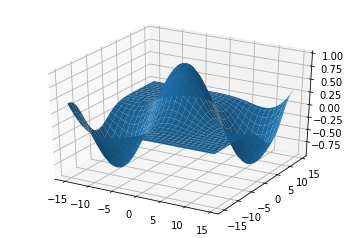

In [3577]:
plot_damp(sigma=4, theta=-0.6, r=15)

## Adaptive DoG Model

$$
F_1 = G_{k_1p}*I_B,\ F_2 = G_{k_2p}*I_B \\
B_1 = sgn(F_1 - thresh_1),\ B_2 = sgn(F_2 - thresh_2) \\
P_B = B_1 - B_2 \\
$$

In [3578]:
def DoG_extract(img, k1, k2, p):
    '''
    k1: float, is the smaller scale for pores and valleys.
    k2: float, is the larger scale for only valleys.
    p: float, mean ridge period.
    '''
    def gaussian2d(shape=(5,5), sigma=0.5):
        """
        2D gaussian mask - should give the same result as MATLAB's
        fspecial('gaussian',[shape],[sigma])
        """
        m, n = [(ss-1.)/2. for ss in shape]
        y, x = np.ogrid[-m:m+1, -n:n+1]
        h = 1 / (math.sqrt(2*math.pi)*sigma) * np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
        h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
        sumh = h.sum()
        if sumh != 0:
            h /= sumh
        # Normalize to zero mean
        h -= h.mean()
        return h
    
    gaussian_kernel_k1p = gaussian2d(shape=(int(k1*p*6), int(k1*p*6)), sigma=k1*p)
    gaussian_kernel_k2p = gaussian2d(shape=(int(k2*p*6), int(k2*p*6)), sigma=k2*p)
    
    conv_g1 = signal.convolve2d(img, gaussian_kernel_k1p, mode="same", boundary="symm")
    conv_g2 = signal.convolve2d(img, gaussian_kernel_k2p, mode="same", boundary="symm")
    
    return conv_g2 - conv_g1
#     # Normalize
#     conv_g1 -=  conv_g1.min()
#     conv_g1 /= conv_g1.max()
#     conv_g2 -=  conv_g2.min()
#     conv_g2 /= conv_g2.max()
    
#     thresh_1, thresh_2 = (0.63, 0.7)
#     bin_g1 = (conv_g1 > thresh_1) * 1.
#     bin_g2 = (conv_g2 > thresh_2) * 1.
#     return bin_g1 - bin_g2
#     return conv_g1 - conv_g2

## Load image

In [3579]:
from skimage import io

img_path = './files/task1img/3.jpg'
img = io.imread(img_path, as_gray=True)

## Normalization
$$
M_0 = 100,\ Var_0 = 100,\ \\
Resize \rightarrow 400\times400
$$

In [3580]:
def normalize(img, m0, var0):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    mean = np.mean(img)
    var = np.mean(img)
    extra = np.sqrt(var0 * (img - mean)**2 / var)
    img_nl = np.where(img > mean, m0 + extra, m0 - extra)
    return img_nl

In [3581]:
import warnings
warnings.filterwarnings('ignore')

# Normalizaiton
img_nl = normalize(img, 100, 100)

# Resize
from skimage import transform

origin_size = img.shape
after_size = (400, 400)

img_rs = transform.resize(img_nl, after_size, mode='reflect')

## Morphology Operation
Structure Element: disk(1)  
**Dilation:** For extracting pores.  
**Erosion:** For calculating ridge orientation and frequency.

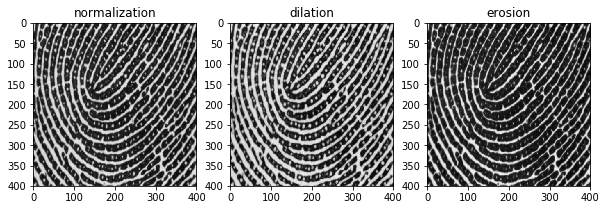

In [3582]:
# Dilation
from skimage.morphology import erosion, dilation, opening, closing, disk, square

img_dl = dilation(img_rs, disk(1))
img_er = erosion(img_rs, disk(1))

# Plot
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.title('normalization')
plt.imshow(img_rs, "gray")
plt.subplot(1, 3, 2)
plt.title('dilation')
plt.imshow(img_dl, "gray")
plt.subplot(1, 3, 3)
plt.title('erosion')
plt.imshow(img_er, "gray")
plt.show()

### Single DoG Model Extraction Test
**Parameters:**
+ $k_1=0.06,\ k_2=0.7$  
+ $p=20$  
+ $thresh_1=0.63,\ thresh_2=0.7$  

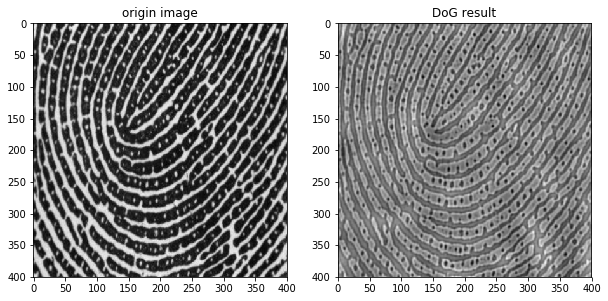

In [3583]:
# Single DoG model test
k1, k2 = (0.06, 0.7)
p = 20
dog_img = DoG_extract(img=img_dl, k1=k1, k2=k2, p=p)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('origin image')
plt.imshow(img_rs, "gray")
plt.subplot(122)
plt.title('DoG result')
plt.imshow(dog_img, "gray")
plt.show()

### Orientation Field Estimation
Gradient Calculation using Sobel or LoG operator.

In [3584]:
# Gradient calculation
from scipy import ndimage

def get_gradient_image(img, mode='sobel', sigma=2):
    '''
    mode: str, "sobel" or "log".
    sigma: int, sigma for Gaussian kernel in LoG.
    '''
    if mode == 'sobel':
        sobel_x_operator = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y_operator = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        G_x = signal.convolve2d(img, sobel_x_operator, mode='same', boundary='symm')
        G_y = signal.convolve2d(img, sobel_y_operator, mode='same', boundary='symm')
    if mode == 'log':
        img_log = ndimage.gaussian_laplace(img, sigma=sigma)
        G_y, G_x = np.gradient(img_log)
    return G_x, G_y

def calculate_dominant_angle(s_, G_x, G_y):
    '''
    s_: slice, slice for part of the img.
    '''
    G_x_part = G_x[s_]
    G_y_part = G_y[s_]
    theta_block = np.arctan2(G_x_part*G_x_part - G_y_part*G_y_part, 2*G_x_part*G_y_part) / 2
    phi_x = np.sum(np.cos(2 * theta_block))
    phi_y = np.sum(np.sin(2 * theta_block))
    theta = math.pi / 4 - math.atan2(phi_y, phi_x) / 2
    return theta

In [3585]:
G_x_sobel, G_y_sobel = get_gradient_image(img=img_dl, mode='sobel')
G_x_log, G_y_log = get_gradient_image(img=img_dl, mode='log', sigma=2)

### Partition

In [3586]:
# Initial window size: 40x40
w = 40

def initial_window_partition_slices(img, w):
    m, n = img.shape
    slice_list = []
    for i in range(m // w):
        for j in range(n // w):
            slice_list.append(np.s_[i*w: (i+1)*w, j*w: (j+1)*w])
    return slice_list

In [3587]:
slice_initial = initial_window_partition_slices(img_rs, w)

In [3588]:
# Function for plotting the partition
def draw_square_with_slice(s_, ax, color="yellow"):
    '''
    s_: np.s_, 2D-slice object describing the shape of a square.
    ax: plt.axes.
    '''
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    ax.plot((x1, x2), (y1, y1), color=color)
    ax.plot((x1, x2), (y2, y2), color=color)
    ax.plot((x1, x1), (y1, y2), color=color)
    ax.plot((x2, x2), (y1, y2), color=color)
    
def draw_angle_with_slice(s_, ax, angle, color="red"):
    angle = angle
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    radius = math.sqrt(abs(x1 - x2))
    ax.plot((x_center - radius * math.sin(angle), x_center + radius * math.sin(angle)), 
            (y_center - radius * math.cos(angle), y_center + radius * math.cos(angle)), color=color)
    
def draw_text_with_slice(s_, ax, text, pos="center", color="red", fontsize=12):
    '''
    pos: str, position to set the text: 
         "center", "left_up", "left_down", "right_up", "right_down".
    '''
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    if pos == "center":
        x, y = (x_center, y_center)
    elif pos == "left_up":
        x, y = (x1, y1)
    elif pos == "left_down":
        x, y = (x1, y2)
    elif pos == "right_up":
        x, y = (x2, y1)
    elif pos == "right_down":
        x, y = (x2, y2)
    ax.text(x, y, text, color=color, fontsize=fontsize)

In [3589]:
# plt.figure("partition", figsize=(10, 10))
# ax = plt.subplot(111)
# plt.title("partition")
# plt.imshow(img_rs, "gray")
# for s_ in slice_initial:
#     draw_square_with_slice(s_, ax)
# plt.show()

### Partition Classfication
+ **Well-defined:** $OC > thresh_1$  
+ **Ill-posed:** $OC < thresh_1\ and\ IC > thresh_2$  
+ **Background:** $OC < thresh_1\ and\ IC < thresh_2$  
$$
Orientation\ Certainty(OC) = \cfrac{(\lambda_{1}-\lambda_{2})^2}
{(\lambda_{1}+\lambda_{2})^2} = \cfrac{(j_{11}-j_{22})^2+4j_{12}^2}{(j_{11}+j_{22})^2} \\
where:\ J = \cfrac{1}{N_B}\sum_{i\in B}\nabla B_i \nabla B_i^T = \left[\begin{matrix}
j_{11} & j_{22} \\ j_{21} & j_{22}\end{matrix}\right],\ \nabla B_i = (G_x(B_i), G_y(B_i))^T \\
Intensity\ Contrast(IC) = std(B)
$$

In [3590]:
# Calculate OC and IC
from functools import reduce

def calculate_oc(s_, G_x, G_y):
    G_x_part = G_x[s_]
    G_y_part = G_y[s_]
    delta_b = np.array([G_x_part.flatten(), G_y_part.flatten()])
    n_b = reduce(lambda x, y: x*y, G_x_part.shape)
    j = delta_b.dot(delta_b.T) / n_b
    oc = ((j[0, 0] - j[1, 1])**2 + 4 * j[0, 1]**2) / (j[0, 0] + j[1, 1])**2
    return oc

def calculate_ic(s_, img):
    return img[s_].var()

In [3591]:
# Get all dominant angles and oc, ic for each initial block
dominant_angles_slice_initial = []
ocs_slice_initial = []
ics_slice_initial = []

for s_ in slice_initial:
    G_x, G_y = (G_x_sobel, G_y_sobel)
    dominant_angles_slice_initial.append(calculate_dominant_angle(s_, G_x, G_y))
    ocs_slice_initial.append(calculate_oc(s_, G_x, G_y))
    ics_slice_initial.append(calculate_ic(s_, img_rs))

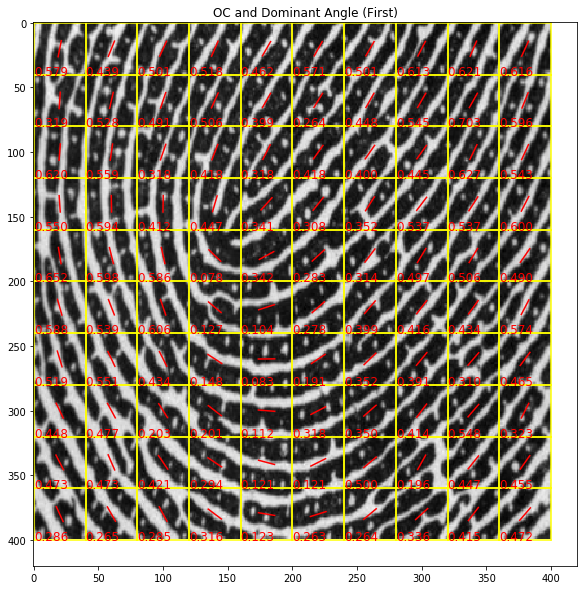

In [3592]:
# Plot result
plt.figure(figsize=(10, 10))
plt.title("OC and Dominant Angle (First)")
ax = plt.subplot(111)
ax.imshow(img_rs, "gray")
for i, s_ in enumerate(slice_initial):
    draw_angle_with_slice(s_, ax, -dominant_angles_slice_initial[i])
    draw_square_with_slice(s_, ax)
    draw_text_with_slice(s_, ax, '%.3f' % ocs_slice_initial[i], pos="left_down")

In [3593]:
def divide_slice_into_four_parts(s_):
    '''
    Divide the origin slice into four slice from center.
    s_  ->  |s1 | s2|
            |s3 | s4|
    '''
    
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    s_1 = np.s_[y1: y_center, x1: x_center]
    s_2 = np.s_[y1: y_center, x_center: x2]
    s_3 = np.s_[y_center: y2, x1: x_center]
    s_4 = np.s_[y_center: y2, x_center: x2]
    return (s_1, s_2, s_3, s_4)

In [3594]:
# Second Partition for ill-posed block
oc_thresh = .25
ic_thresh = 1.

slice_second = []

# First OC
for i, s_ in enumerate(slice_initial):
    if ocs_slice_initial[i] < oc_thresh:
        slice_second.extend(divide_slice_into_four_parts(s_))
    else:
        slice_second.append(s_)

# Second OC
dominant_angles_slice_second = []
ocs_slice_second = []
ics_slice_second = []

for s_ in slice_second:
    G_x, G_y = (G_x_sobel, G_y_sobel)
    dominant_angles_slice_second.append(calculate_dominant_angle(s_, G_x, G_y))
    ocs_slice_second.append(calculate_oc(s_, G_x, G_y))
    ics_slice_second.append(calculate_ic(s_, img_er))

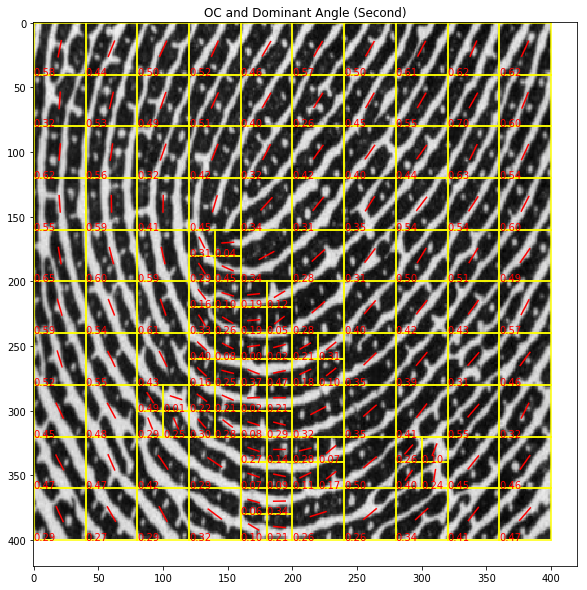

In [3595]:
# Plot result
plt.figure(figsize=(10, 10))
plt.title("OC and Dominant Angle (Second)")
ax = plt.subplot(111)
ax.imshow(img_rs, "gray")
for i, s_ in enumerate(slice_second):
    draw_angle_with_slice(s_, ax, -dominant_angles_slice_second[i])
    draw_square_with_slice(s_, ax)
#     draw_text_with_slice(s_, ax, '%s' % i, pos="center", fontsize=10)
    draw_text_with_slice(s_, ax, '%.2f' % ocs_slice_second[i], pos="left_down", fontsize=10, color="red")

### Frequency Estimation

In [3596]:
def calculate_frequency(s_, img, angle, plot_freq=False, plot_area=False):
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    w = int(abs(y2 - y1) * 0.75)
    # Boundary move
    x_min = 0
    y_min = 0
    x_max = img.shape[1]
    y_max = img.shape[0]
    samples = []
    for i in range(-w, w + 1):
        u_samples = []
        v_samples = []
        x_u = x_center + i * math.cos(angle)
        y_v = y_center + i * math.sin(angle)
        for j in range(-w // 2, w // 2 + 1):
            x_u_sample = x_u + j * math.sin(-angle)
            y_v_sample = y_v + j * math.cos(-angle)
            u_samples.append(x_u_sample)
            v_samples.append(y_v_sample)
            x_min = min(x_min, x_u_sample)
            y_min = min(y_min, y_v_sample)
            x_max = max(x_max, x_u_sample + 1)
            y_max = max(y_max, y_v_sample + 1)
        samples.append((u_samples, v_samples))
    # Adjust boundary
    samples_mean = []
    for u_samples, v_samples in samples:
        u_samples = [u + (-x_min) for u in u_samples]
        v_samples = [v + (-y_min) for v in v_samples]
        u_samples = [u - (x_max - img.shape[1]) for u in u_samples]
        v_samples = [v - (y_max - img.shape[0]) for v in v_samples]
        pixel_gray = []
        for i in range(len(u_samples)):
            # Get mean gray-scale
            pixel = img[int(v_samples[i])][int(u_samples[i])]
            pixel_gray.append(pixel)
        pixel_mean = sum(pixel_gray) / len(pixel_gray)
        samples_mean.append(pixel_mean)
    samples_mean = [i - min(samples_mean) for i in samples_mean]
    # Plot area
    img_area = np.zeros(img.shape)
    if plot_area:
        plt.figure()
        for u_samples, v_samples in samples:
            u_samples = [u + (-x_min) for u in u_samples]
            v_samples = [v + (-y_min) for v in v_samples]
            u_samples = [u - (x_max - img.shape[1]) for u in u_samples]
            v_samples = [v - (y_max - img.shape[0]) for v in v_samples]
            for i in range(len(u_samples)):
                img_area[int(v_samples[i])][int(u_samples[i])] = img[int(v_samples[i])][int(u_samples[i])]
        plt.imshow(img_area)
    # Plot freq
    if plot_freq:
        plt.figure()
        plt.plot(list(range(len(samples_mean))), samples_mean)
        samples_mean_sub = [(samples_mean[i] + samples_mean[i-1] + samples_mean[i+1]) / 3 for i in range(1, len(samples_mean) - 1)]
        plt.plot(list(range(len(samples_mean_sub))), samples_mean_sub)
        plt.plot([0, len(samples_mean_sub)], [sum(samples_mean_sub) / len(samples_mean_sub), sum(samples_mean_sub) / len(samples_mean_sub)])
        plt.plot([0, len(samples_mean)], [sum(samples_mean) / len(samples_mean), sum(samples_mean) / len(samples_mean)])
        plt.show()
    # Calculate frequency by zero-cross
    cross = []
    samples_mean_sub = [i - sum(samples_mean) / len(samples_mean) for i in samples_mean]
    for i in range(0, len(samples_mean_sub) - 1):
        if samples_mean_sub[i] * samples_mean_sub[i+1] < 0:
            cross.append(i)
    # Remove false cross
    same_ridge_thresh = 5
    new_cross = []
    if len(cross) > 2:
        for i in range(len(cross) - 1):
            if not abs(cross[i] - cross[i+1]) < same_ridge_thresh:
                new_cross.append(cross[i])
    if len(cross) < 2:
        return int(w * 1.5)
    return (cross[-1] - cross[0]) / (len(cross) - 1) * 2

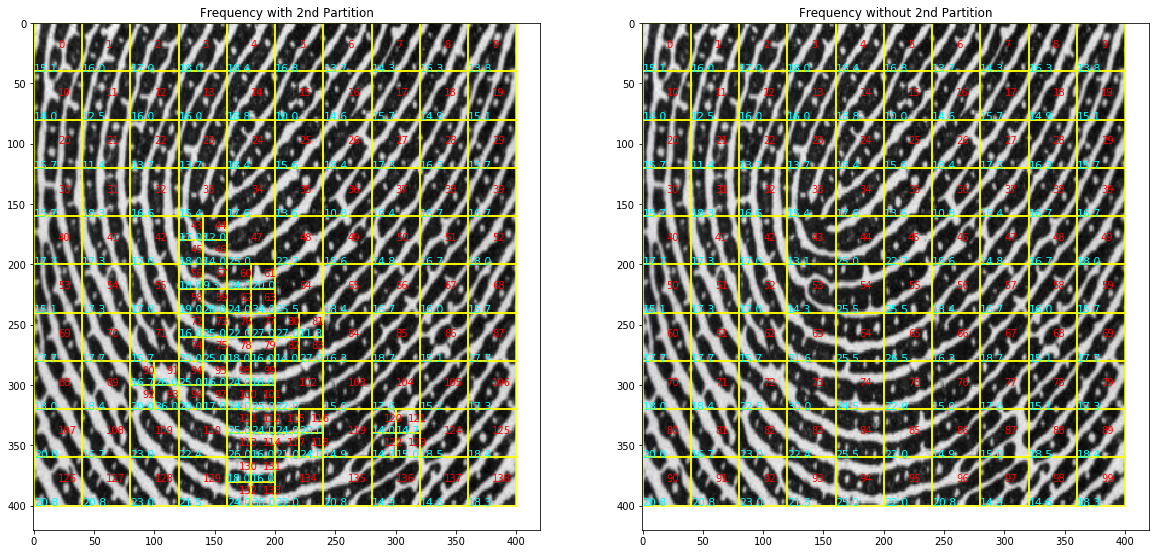

In [3597]:
# Plot result
frequency_slice_second = []

plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
ax.imshow(img_rs, "gray")
plt.title("Frequency with 2nd Partition")
for i, s_ in enumerate(slice_second):
    freqency = calculate_frequency(s_=s_, img=img_er, angle=dominant_angles_slice_second[i])
    frequency_slice_second.append(freqency)
    draw_square_with_slice(s_, ax)
    draw_text_with_slice(s_, ax, '%.1f' % freqency, pos="left_down", fontsize=11, color='cyan')
    draw_text_with_slice(s_, ax, '%s' % i, pos="center", fontsize=10, color='red')

frequency_slice_initial = []

ax = plt.subplot(122)
ax.imshow(img_rs, "gray")
plt.title("Frequency without 2nd Partition")
for i, s_ in enumerate(slice_initial):
    freqency = calculate_frequency(s_=s_, img=img_er, angle=dominant_angles_slice_initial[i])
    frequency_slice_initial.append(freqency)
    draw_square_with_slice(s_, ax)
    draw_text_with_slice(s_, ax, '%.1f' % freqency, pos="left_down", fontsize=11, color='cyan')
    draw_text_with_slice(s_, ax, '%s' % i, pos="center", fontsize=10, color='red')
plt.show()

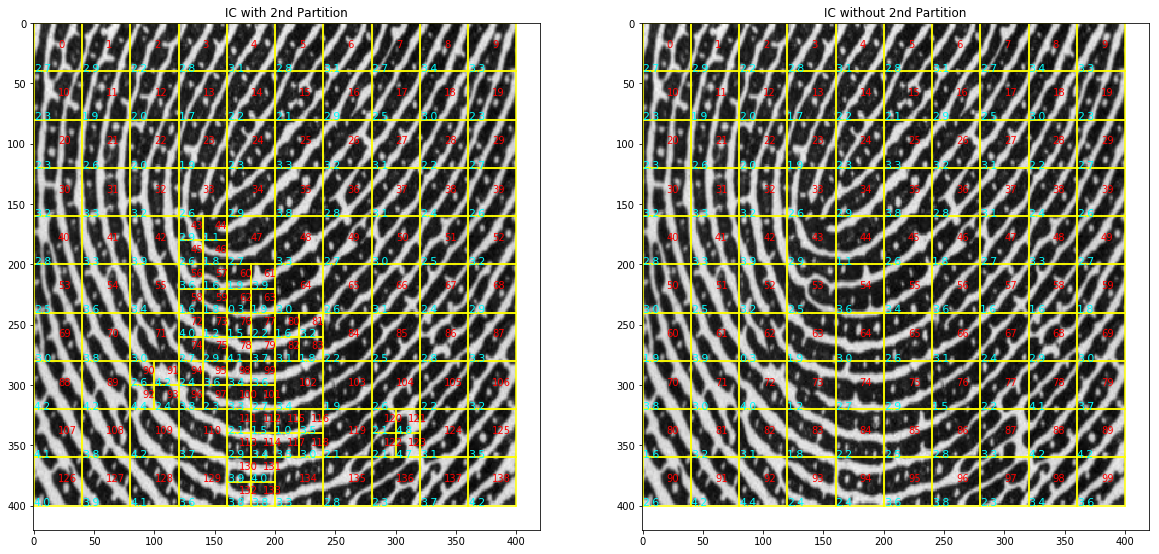

In [3598]:
# Plot IC
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
ax.imshow(img_rs, "gray")
plt.title("IC with 2nd Partition")
for i, s_ in enumerate(slice_second):
    ic = ics_slice_second[i]
    draw_square_with_slice(s_, ax)
    draw_text_with_slice(s_, ax, '%.1f' % ic, pos="left_down", fontsize=11, color='cyan')
    draw_text_with_slice(s_, ax, '%s' % i, pos="center", fontsize=10, color='red')

ax = plt.subplot(122)
ax.imshow(img_rs, "gray")
plt.title("IC without 2nd Partition")
for i, s_ in enumerate(slice_initial):
    ic = ics_slice_second[i]
    draw_square_with_slice(s_, ax)
    draw_text_with_slice(s_, ax, '%.1f' % ic, pos="left_down", fontsize=11, color='cyan')
    draw_text_with_slice(s_, ax, '%s' % i, pos="center", fontsize=10, color='red')
plt.show()

### Gabor Filter Bank

In [3599]:
from skimage.filters import gabor_kernel, gabor

def get_gabor_result_for_slice(s_, img, angle, frequency):
    frequency = 1 / frequency
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    w = int(abs(y2 - y1) / 2)
    larger_s_ = np.s_[max(y1 - w, 0): min(y2 + w, img.shape[0]), 
                      max(x1 - w, 0): min(x2 + w, img.shape[1])]
    img_part = img[larger_s_]
#     plt.figure()
#     plt.imshow(img_part, "gray")
    filt_real, filt_imag = gabor(img_part, frequency, theta=angle, bandwidth=10, sigma_x=5, sigma_y=5)
#     plt.figure()
#     plt.imshow(filt_real, "gray")
    # New coordination
    new_x1 = w if x1 > w else x1
    new_x2 = w + x2 - x1 if x1 > w else x2
    new_y1 = w if y1 > w else y1
    new_y2 = w + y2 - y1 if y1 > w else y2
    
    gabor_result = filt_real[new_y1: new_y2, new_x1: new_x2]
#     gabor_result = normalize(gabor_result, m0=100, var0=100)
    gabor_result -= gabor_result.min()
    gabor_result /= gabor_result.max()
    return gabor_result

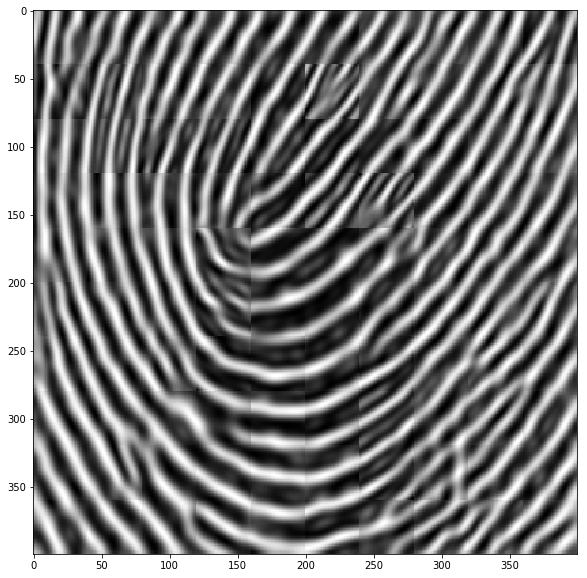

In [3600]:
img_gabor = np.zeros(img_rs.shape)
for i, s_ in enumerate(slice_initial):
# for i, s_ in enumerate(slice_second):
#     gabor_result = get_gabor_result_for_slice(slice_second[i], img_rs, dominant_angles_slice_second[i], frequency_slice_second[i])
    gabor_result = get_gabor_result_for_slice(slice_initial[i], img_rs, dominant_angles_slice_initial[i], frequency_slice_initial[i])
    img_gabor[s_] = gabor_result
plt.figure(figsize=(10, 10))
plt.imshow(img_gabor, "gray")
plt.show()

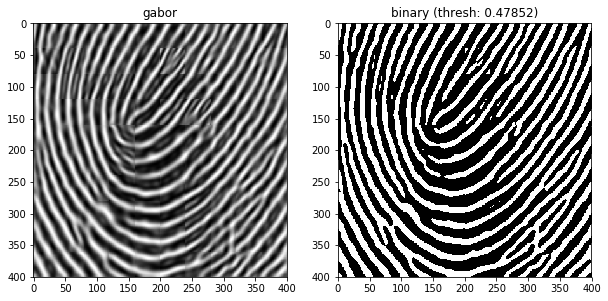

In [3601]:
from skimage import filters

thresh = filters.threshold_otsu(img_gabor)
img_gabor_bin = (img_gabor >= thresh) * 1.0

# Remove background
ic_thresh = 0.2

img_gabor_bin_rb = img_gabor_bin.copy()
for i, s_ in enumerate(slice_second):
    if ics_slice_second[i] <= ic_thresh:
        img_gabor_bin_rb[s_] = np.ones(shape=img_gabor_bin_rb.shape)[s_]
img_gabor_bin = img_gabor_bin_rb
        
plt.figure('thresholding', figsize=(10, 5))
plt.subplot(121)
plt.title('gabor')
plt.imshow(img_gabor, plt.cm.gray)
plt.subplot(122)
plt.title('binary (thresh: %.5f)' % thresh)
plt.imshow(img_gabor_bin, plt.cm.gray)
plt.show()

In [3602]:
img_gabor_bin_rs = transform.resize(img_gabor_bin, origin_size)

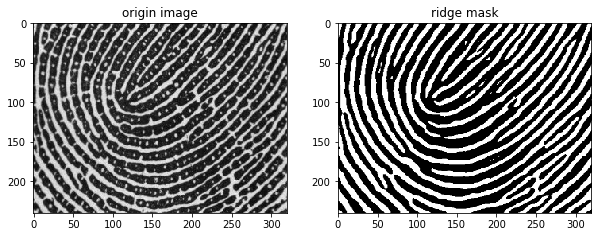

In [3603]:
from skimage.morphology import binary_dilation, binary_erosion, binary_closing, binary_opening, square

se = square(1)
img_gabor_bin_rs_dl = binary_erosion(img_gabor_bin_rs, se)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('origin image')
plt.imshow(img, "gray")
plt.subplot(122)
plt.title('ridge mask')
plt.imshow(img_gabor_bin_rs, "gray")
plt.show()

### Pore Extraction
+ **Well-defined:** DAMP  
+ **Ill-posed:** DoG

In [3604]:
# Single Thresh
pore_extract_result_single_thresh = np.zeros(img_rs.shape)

for i, s_ in enumerate(slice_second):
    theta = dominant_angles_slice_second[i]
    frequency = frequency_slice_second[i]
    
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    w = int(abs(y2 - y1) / 2)
    larger_s_ = np.s_[max(y1 - w, 0): min(y2 + w, img_rs.shape[0]), 
                      max(x1 - w, 0): min(x2 + w, img_rs.shape[1])]
    img_part = img_rs[larger_s_]
    img_part = img_part.max() - img_part
    # New coordination
    new_x1 = w if x1 > w else x1
    new_x2 = w + x2 - x1 if x1 > w else x2
    new_y1 = w if y1 > w else y1
    new_y2 = w + y2 - y1 if y1 > w else y2
    
    # Partition type
    oc_thresh = 0
    if ocs_slice_second[i] > oc_thresh:
        k = 12
        sigma = freqency / k
        r = int(3*sigma)
        damp_model = DAMP_with_angle(sigma, theta, r)
        img_damp = signal.convolve2d(img_part, damp_model, mode='same', boundary='symm')
        img_damp -= img_damp.min()
        img_damp /= img_damp.max()
        
        pore_extract_result_single_thresh[s_] = img_damp[new_y1: new_y2, new_x1: new_x2]
    else:
        k1, k2 = (0.07, 0.7)
        p = freqency
        img_dog = DoG_extract(img=img_part, k1=k1, k2=k2, p=p)
        img_dog -= img_dog.min()
        img_dog /= img_dog.max()
        pore_extract_result_single_thresh[s_] = img_dog[new_y1: new_y2, new_x1: new_x2]

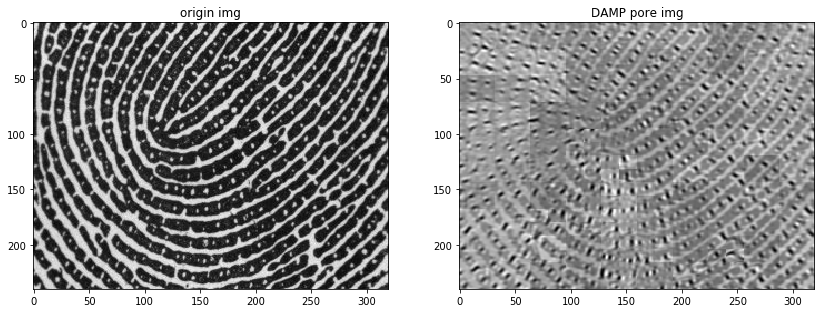

In [3605]:
# Single Thresh
pore_extract_result_single_thresh_rs = transform.resize(pore_extract_result_single_thresh, origin_size)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('origin img')
plt.imshow(img, "gray")
plt.subplot(122)
plt.title('DAMP pore img')
plt.imshow(pore_extract_result_single_thresh_rs, "gray")
plt.show()

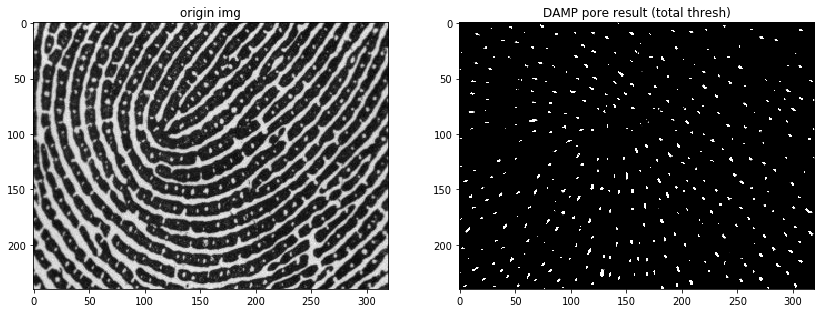

In [3606]:
thresh = 0.25
pore_extract_result_single_thresh_bin = pore_extract_result_single_thresh_rs <= thresh
pore_extract_result_single_thresh_bin = pore_extract_result_single_thresh_bin * (1-img_gabor_bin_rs)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('origin img')
plt.imshow(img, "gray")
plt.subplot(122)
plt.title('DAMP pore result (total thresh)')
plt.imshow(pore_extract_result_single_thresh_bin, "gray")
plt.show()

In [3607]:
pore_extract_result_block_thresh = np.zeros(img_rs.shape)

for i, s_ in enumerate(slice_second):
    theta = dominant_angles_slice_second[i]
    frequency = frequency_slice_second[i]
    
    y1, y2 = (s_[0].start, s_[0].stop)
    x1, x2 = (s_[1].start, s_[1].stop)
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    w = int(abs(y2 - y1) / 2)
    larger_s_ = np.s_[max(y1 - w, 0): min(y2 + w, img_rs.shape[0]), 
                      max(x1 - w, 0): min(x2 + w, img_rs.shape[1])]
#     img_part = dilation(img_rs, square(2))[larger_s_]
    img_part = img_dl[larger_s_]
    img_part = img_part.max() - img_part
    # New coordination
    new_x1 = w if x1 > w else x1
    new_x2 = w + x2 - x1 if x1 > w else x2
    new_y1 = w if y1 > w else y1
    new_y2 = w + y2 - y1 if y1 > w else y2
    
    # Partition type
    oc_thresh = 0
    if ocs_slice_second[i] > oc_thresh:
        k = 12
        sigma = freqency / k
        r = int(3*sigma)
        damp_model = DAMP_with_angle(sigma, theta, r)
        img_damp = signal.convolve2d(img_part, damp_model, mode='same', boundary='symm')
        img_damp -= img_damp.min()
        img_damp /= img_damp.max()
        img_damp = 1 - img_damp
        # Binary
        img_damp_max = img_damp.max()
        img_damp_mean = img_damp.mean()
        ic_thresh = .001
        
        img_damp_var = img_damp[new_y1: new_y2, new_x1: new_x2].var()
        if img_damp[new_y1: new_y2, new_x1: new_x2].var() > ic_thresh:
            img_damp_bin = (img_damp[new_y1: new_y2, new_x1: new_x2] >= (img_damp_max - img_damp_mean) * (0.3 + 6.4 * img_damp_var) + img_damp_mean) * 1.
            pore_extract_result_block_thresh[s_] = img_damp_bin
    else:
        k1, k2 = (0.06, 0.7)
        p = freqency
        img_dog = DoG_extract(img=img_part, k1=k1, k2=k2, p=p)
        img_dog -= img_dog.min()
        img_dog /= img_dog.max()
        pore_extract_result_damp[s_] = img_dog[new_y1: new_y2, new_x1: new_x2]

In [3608]:
# pore_extract_result_block_thresh = np.zeros(img_rs.shape)

# for i, s_ in enumerate(slice_initial):
#     theta = dominant_angles_slice_initial[i]
#     frequency = frequency_slice_initial[i]
    
#     y1, y2 = (s_[0].start, s_[0].stop)
#     x1, x2 = (s_[1].start, s_[1].stop)
#     x_center = int((x1 + x2) / 2)
#     y_center = int((y1 + y2) / 2)
#     w = int(abs(y2 - y1) / 2)
#     larger_s_ = np.s_[max(y1 - w, 0): min(y2 + w, img_rs.shape[0]), 
#                       max(x1 - w, 0): min(x2 + w, img_rs.shape[1])]
#     img_er_sli = erosion(img_rs, square(2))
#     img_part = img_er_sli[larger_s_]
#     img_part = img_part.max() - img_part
#     # New coordination
#     new_x1 = w if x1 > w else x1
#     new_x2 = w + x2 - x1 if x1 > w else x2
#     new_y1 = w if y1 > w else y1
#     new_y2 = w + y2 - y1 if y1 > w else y2
    
#     # Partition type
#     oc_thresh = 0
#     if ocs_slice_initial[i] > oc_thresh:
#         k = 12
#         sigma = freqency / k
#         r = int(3*sigma)
#         damp_model = DAMP_with_angle(sigma, theta, r)
#         img_damp = signal.convolve2d(img_part, damp_model, mode='same', boundary='symm')
#         img_damp -= img_damp.min()
#         img_damp /= img_damp.max()
#         img_damp = 1 - img_damp
#         # Binary
#         img_damp_max = img_damp.max()
#         img_damp_mean = img_damp.mean()
#         ic_thresh = .001
        
#         img_damp_var = img_damp[new_y1: new_y2, new_x1: new_x2].var()
#         if img_damp[new_y1: new_y2, new_x1: new_x2].var() > ic_thresh:
#             img_damp_bin = (img_damp[new_y1: new_y2, new_x1: new_x2] >= (img_damp_max - img_damp_mean) * (0.3 + 7 * img_damp_var) + img_damp_mean) * 1.
#             pore_extract_result_block_thresh[s_] = img_damp_bin
#     else:
#         k1, k2 = (0.06, 0.7)
#         p = freqency
#         img_dog = DoG_extract(img=img_part, k1=k1, k2=k2, p=p)
#         img_dog -= img_dog.min()
#         img_dog /= img_dog.max()
#         pore_extract_result_damp[s_] = img_dog[new_y1: new_y2, new_x1: new_x2]

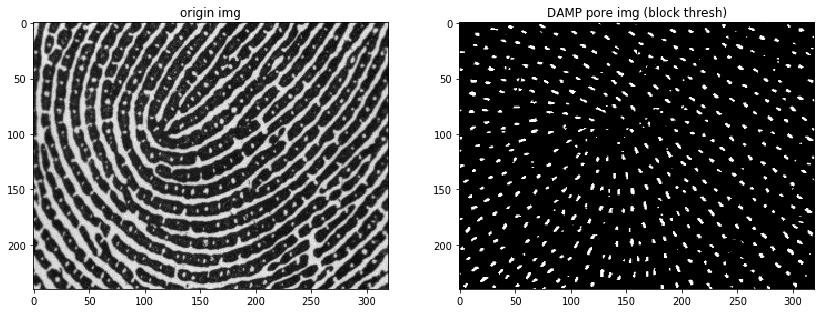

In [3609]:
pore_extract_result_block_thresh_rs = transform.resize(pore_extract_result_block_thresh, origin_size)
pore_extract_result_block_thresh_bin = pore_extract_result_block_thresh_rs * (1-img_gabor_bin_rs)

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('origin img')
plt.imshow(img, "gray")
plt.subplot(122)
plt.title('DAMP pore img (block thresh)')
plt.imshow(pore_extract_result_block_thresh_bin, "gray")
plt.show()

### Measure Pores and Save

**Plot Results of Total Thresh and Block Thresh**

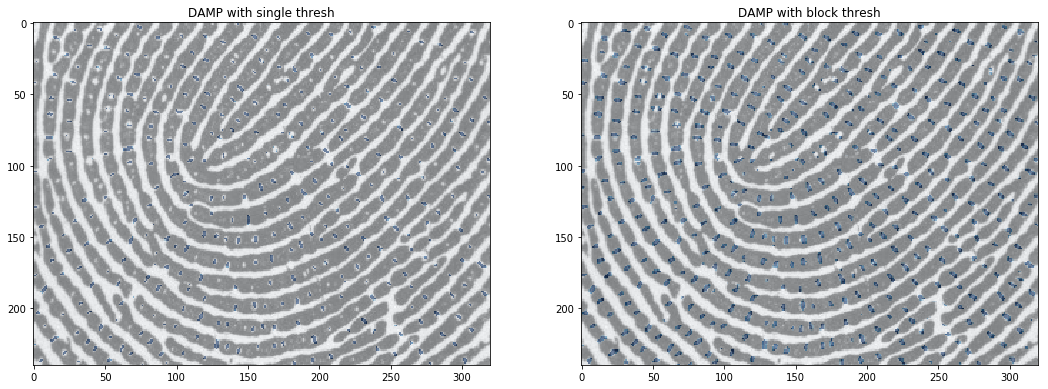

In [3610]:
# Plot result
plt.figure(figsize=(18, 9))
plt.subplot(121)
plt.title('DAMP with single thresh')
plt.imshow(img, "gray")
plt.imshow(pore_extract_result_single_thresh_bin, "Blues", alpha=0.5)
plt.subplot(122)
plt.title('DAMP with block thresh')
plt.imshow(img, "gray")
plt.imshow(pore_extract_result_block_thresh_bin, "Blues", alpha=0.5)
plt.show()

## Post Process

### Label Connected Domain

In [3611]:
# from skimage import morphology, measure

# extracted_pores_labeled_damp = measure.label(pore_extract_result_block_thresh_bin, connectivity=2)

from scipy.ndimage import measurements

eight_connected_structure = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
extracted_pores_labeled_damp, num_pores = measurements.label(pore_extract_result_block_thresh_bin, structure=eight_connected_structure)

### Detect Similar Pores

In [3612]:
# Detect similar pores
# Delete after mean
from collections import OrderedDict

def euclidean_distance(p1, p2):
    '''
    p1, p2: tuple. The coordinates of a point.
    '''
    p1 = np.array(p1)
    p2 = np.array(p2)
    return np.sum((p1 - p2)**2)**0.5
    
extracted_pores_coordinates = []

for i in range(1, int(extracted_pores_labeled_damp.max())):
    y = min(int(np.argwhere(extracted_pores_labeled_damp == i)[:, 0].mean()), img.shape[0])
    x = min(int(np.argwhere(extracted_pores_labeled_damp == i)[:, 1].mean()), img.shape[1])
    extracted_pores_coordinates.append((y, x))

result_pores_coordinates = extracted_pores_coordinates
dist_thresh = 6.3
last_pores_number = 0

while True:
    # Calculate dist matrix
    pores_num = len(result_pores_coordinates)
    dist_matrix = np.zeros(shape=(pores_num, pores_num))
    result_pores = []
    for i in range(pores_num):
        for j in range(i, pores_num):
            dist_matrix[i][j] = euclidean_distance(result_pores_coordinates[i], result_pores_coordinates[j])
    if not np.any((dist_matrix > np.finfo(float).eps) & (dist_matrix <= dist_thresh)):
        break
    else:
        filtered_points_ids = np.argwhere((dist_matrix > np.finfo(float).eps) & (dist_matrix <= dist_thresh))
        pair_set_list = []
        pair_set_list_undup = []
        for x, y in filtered_points_ids:
            pair_set_list.append(set([x, y]))
        for pair_set in pair_set_list:
            if len(pair_set_list_undup) == 0:
                pair_set_list_undup.append(pair_set)
                continue
            has_intersection = False
            for i in range(len(pair_set_list_undup)):
                if pair_set & pair_set_list_undup[i]:
                    pair_set_list_undup[i] = pair_set_list_undup[i] | pair_set
                    has_intersection = True
            if not has_intersection:
                pair_set_list_undup.append(pair_set)
        coord_with_dup = set()
        for pair_set in pair_set_list_undup:
            coord_with_dup = coord_with_dup | pair_set
        for i, coordinates in enumerate(result_pores_coordinates):
            if not i in coord_with_dup:
                result_pores.append(coordinates)
        for pair_set in pair_set_list_undup:
            x_sum, y_sum = (0, 0)
            for c in pair_set:
                x_sum += result_pores_coordinates[c][0]
                y_sum += result_pores_coordinates[c][1]
            result_pores.append((min(int(x_sum / len(pair_set)), img.shape[0]), min(int(y_sum / len(pair_set)), img.shape[1])))
        result_pores_coordinates = result_pores
            
print('Before delete: %s\nAfter delete: %s' % (len(extracted_pores_coordinates), len(result_pores_coordinates)))

Before delete: 479
After delete: 452


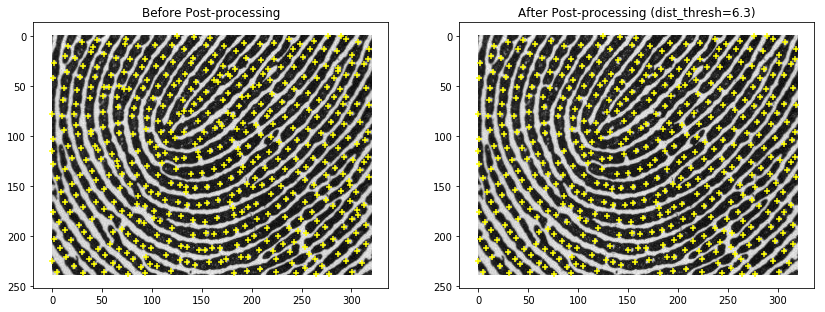

In [3613]:
# Plot postprocess result
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('Before Post-processing')
plt.imshow(img, "gray")
plt.scatter([p[1] for p in extracted_pores_coordinates], [p[0] for p in extracted_pores_coordinates], marker='+', color="yellow")

plt.subplot(122)
plt.title('After Post-processing (dist_thresh=%s)' % dist_thresh)
plt.imshow(img, "gray")
plt.scatter([p[1] for p in result_pores_coordinates], [p[0] for p in result_pores_coordinates], marker='+', color="yellow")
plt.show()

In [3614]:
# output_dir = './measure/dets_dir/'
output_dir = './measure/results/'

# with open(output_dir + img_path[img_path.rfind('/')+1:][:-4] + '.txt', 'w') as txt:
#     for i in range(1, int(extracted_pores_labeled_damp.max())):
#         y = int(np.argwhere(extracted_pores_labeled_damp == i)[:, 0].mean())
#         x = int(np.argwhere(extracted_pores_labeled_damp == i)[:, 1].mean())
#         txt.write('%s %s\n' % (y, x))

with open(output_dir + img_path[img_path.rfind('/')+1:][:-4] + '.txt', 'w') as txt:
    for x, y in result_pores_coordinates:
        txt.write('%s %s\n' % (x, y))